2024-12-16 00:33:37.506526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Activities with >80% False motion_value:
PID: P06, Activity: FFSIT, Proportion of False: 1.00
PID: P11, Activity: FFSIT, Proportion of False: 0.96


/var/folders/xt/j055vd5n66x6nhkm2f0zzg2w0000gn/T/ipykernel_79392/2638742876.py:229: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])


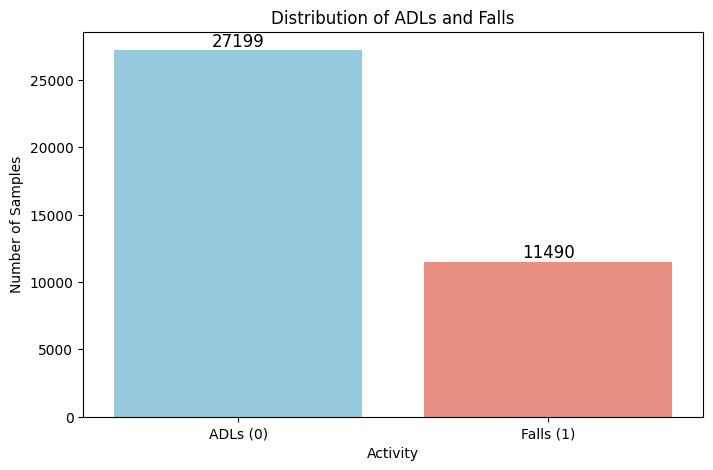

Index(['timestamp', 'motion_value', 'light', 'temp', 'breathingRate',
       'heartRate', 'physiologicalState', 'targetDistance_filtered',
       'health_idx', 'PID', 'activity_name', 'class', 'base_activity',
       'environmental_index'],
      dtype='object')


In [1]:
# !pip install numpy pandas scikit-learn imbalanced-learn matplotlib tensorflow seaborn

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, LSTM, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def remove_zero_readings(df, threshold=10):
    """Remove records with zero readings above threshold."""
    # Track problematic sensor combinations
    zero_readings = pd.DataFrame()
    for sensor in ['breathingRate', 'heartRate']:
        zero_counts = df[df[sensor] == 0.0].groupby(['PID', 'activity_name'])[sensor].count()
        zero_readings = pd.concat([zero_readings, zero_counts[zero_counts > threshold]])
    
    # Remove identified problematic records
    outlier_indices = zero_readings.index.drop_duplicates()
    return df[~df.set_index(['PID', 'activity_name']).index.isin(outlier_indices)]


df = pd.read_csv("combined_sensor_data-all-7.csv")

# ignore one hot encoded and netatmo and static 
# health_idx_columns = ['health_idx_0', 'health_idx_1', 'health_idx_2', 'health_idx_3', 'health_idx_4']
# physiologicalState_columns = ['physiologicalState_0', 'physiologicalState_1', 'physiologicalState_2','physiologicalState_3', 'physiologicalState_4']
# df = df.drop(['targetDistance','CO2','Humidity','Noise','Pressure','AbsolutePressure',
            #   'age','gender','height','weight','fitness_level'] + physiologicalState_columns + health_idx_columns, axis=1)

# remove redundant 
df = df.drop(['targetDistance', 'AbsolutePressure'], axis=1)

# feature engineering 
def combine_ambient(df, ambient_features):
    # Step 1: Select only ambient sensor features (CO2, Humidity, Noise, Pressure)
    ambient_df = df[ambient_features]

    # Step 2: Handle NaN values by filling with the mean
    ambient_df = ambient_df.fillna(ambient_df.mean())

    # Step 3: Standardize the ambient sensor features
    scaler = StandardScaler()
    ambient_features_scaled = scaler.fit_transform(ambient_df)
    # Step 4: Apply PCA to create the Environmental Index
    pca = PCA(n_components=1)  # Aggregate into a single component
    env_index = pca.fit_transform(ambient_features_scaled)
    # Add the Environmental Index to the original DataFrame
    df['environmental_index'] = env_index
    # Display the updated DataFrame
    # df.drop(ambient_features)
    # print(df.columns)
    df = df.drop(ambient_features, axis=1)
    return df


# Define the activities
fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]
non_fall_activities = ["LOB", "RS", "SBS", "SIT", "SSS", 'SSW', "SWW", "TWC", "WAT", 'WSS']
ambient_features = ['CO2', 'Humidity', 'Noise', 'Pressure']

def remove_low_motion_activities(df, threshold=0.8):
    """
    Print and remove fall activities where motion_value is False 
    for more than the threshold percentage of the activity's duration.
    """
    # List of fall activities to check
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    # Filter for fall activities only
    falls_df = df[df['activity_name'].isin(fall_activities)]

    # Calculate percentage of False motion values for each (PID, activity_name)
    motion_stats = (
        falls_df.groupby(['PID', 'activity_name'])['motion_value']
        .apply(lambda x: (x == False).mean())  # Calculate proportion of False values
    )

    # Identify activities to print and remove based on the threshold
    activities_to_remove = motion_stats[motion_stats > threshold]

    # Print the activity names and their proportions before removing
    print("Activities with >80% False motion_value:")
    for (pid, activity_name), proportion in activities_to_remove.items():
        print(f"PID: {pid}, Activity: {activity_name}, Proportion of False: {proportion:.2f}")

    # Remove identified activities from the DataFrame
    return df[~df.set_index(['PID', 'activity_name']).index.isin(activities_to_remove.index)]

def identify_and_remove_outliers_combined(df):
    """
    Identify outliers for both ADL and Fall activities using IQR and remove them from the dataset.
    Retain all other information and merge cleaned activities back.
    """
    # Group by base_activity, class, and PID to calculate the duration per activity
    duration_counts = df.groupby(['base_activity', 'class', 'PID']).size().reset_index(name='duration')

    # Separate ADLs and Falls
    adls = duration_counts[duration_counts['class'] == 0]  # ADL activities
    falls = duration_counts[duration_counts['class'] == 1]  # Fall activities

    # Helper function to identify and clean outliers using IQR
    def clean_outliers(data):
        outliers = []
        cleaned_data = []

        for activity in data['base_activity'].unique():
            activity_data = data[data['base_activity'] == activity]
            Q1 = activity_data['duration'].quantile(0.25)
            Q3 = activity_data['duration'].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers and non-outliers
            activity_outliers = activity_data[
                (activity_data['duration'] < lower_bound) | (activity_data['duration'] > upper_bound)
            ]
            activity_cleaned = activity_data[
                (activity_data['duration'] >= lower_bound) & (activity_data['duration'] <= upper_bound)
            ]

            outliers.append(activity_outliers)
            cleaned_data.append(activity_cleaned)

        # Combine all outliers and cleaned data
        all_outliers = pd.concat(outliers, ignore_index=True)
        all_cleaned_data = pd.concat(cleaned_data, ignore_index=True)

        return all_outliers, all_cleaned_data

    # Clean outliers for ADLs and Falls separately
    adl_outliers, cleaned_adls = clean_outliers(adls)
    fall_outliers, cleaned_falls = clean_outliers(falls)

    # Print identified outliers
    print("\nIdentified ADL Outliers:")
    print(adl_outliers[['base_activity', 'PID', 'duration']])

    print("\nIdentified Fall Outliers:")
    print(fall_outliers[['base_activity', 'PID', 'duration']])

    # Combine cleaned ADLs and Falls
    cleaned_df = pd.concat([cleaned_adls, cleaned_falls], ignore_index=True)

    # Merge cleaned activities with the original DataFrame to retain all columns
    final_df = df.merge(cleaned_df[['base_activity', 'PID']], on=['base_activity', 'PID'], how='inner')

    return final_df


# 2. Apply cleaning steps
df = remove_zero_readings(df)
df['motion_value'] = df['motion_value'].astype(int)
df = remove_low_motion_activities(df)
# df_2 = identify_and_remove_outliers_combined(df)

df_clean = df.drop(ambient_features, axis=1)
df_ambient = combine_ambient(df, ambient_features)

def filter_activities(df):
    # Define relevant fall activities
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    non_fall_activities = [
            "LOB", "RS", "SBS", 
            "SWW", "TWC", "WAT", 
            'WSS', 'SSW', 'SSS'
        ]

    # Filter the dataset to keep only relevant activities
    df_filtered = df[df['base_activity'].isin(fall_activities + non_fall_activities)]
    return df_filtered

final_df_clean = filter_activities(df_clean)
final_df_ambient = filter_activities(df_ambient)

def plot_class_distribution(df):
    """
    Plot the distribution of ADLs (class=0) and Falls (class=1) with sample counts.
    """
    # Get the class distribution
    class_counts = df['class'].value_counts().reset_index()
    class_counts.columns = ['class', 'count']
    class_counts['label'] = class_counts['class'].apply(lambda x: 'ADLs (0)' if x == 0 else 'Falls (1)')

    # Plot the distribution using a bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])

    # Add labels on top of the bars
    for index, row in class_counts.iterrows():
        plt.text(index, row['count'], f'{row["count"]}', ha='center', va='bottom', fontsize=12)

    # Add plot labels and title
    plt.title("Distribution of ADLs and Falls")
    plt.xlabel("Activity")
    plt.ylabel("Number of Samples")
    plt.show()

plot_class_distribution(df_clean)

# final_df
# 19195/10583
# print(len(final_df_clean.columns)) # 14 features
# print(final_df_clean.columns) # 14 features
print(final_df_ambient.columns) # 14 features
# print(df_clean.columns) # 14 features with all ADLs

# print(df_clean.shape)
# print(final_df_clean.shape)

# CNN-LSTM

In [3]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, TimeDistributed
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

def build_cnn_lstm_hybrid_model_2(input_shape, optimizer='adam', filters=32, kernel_size=3, lstm_units=64, learning_rate=0.001):
    model = Sequential([
        # tf.keras.Input(shape=(window_size, X_train.shape[2])),
        tf.keras.Input(shape=input_shape),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        LSTM(lstm_units, activation='tanh', return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# def build_cnn_lstm_hybrid_model(input_shape, optimizer='adam', filters=32, kernel_size=3, lstm_units=64, learning_rate=0.001):
#     model = Sequential()
#     # Reshape input_shape for Conv1D
#     # Expected input_shape is (timesteps, features) 
#     model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
#     model.add(Flatten())  # Flatten the output of Conv1D
#     model.add(LSTM(lstm_units))  # LSTM layer
#     model.add(Dense(1, activation='sigmoid'))  # Output layer

#     if optimizer == 'adam':
#         opt = Adam(learning_rate=learning_rate)
#     elif optimizer == 'rmsprop':
#         opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     return model


def build_cnn_lstm_hybrid_model(input_shape, optimizer='adam', filters=32, kernel_size=3, lstm_units=64, learning_rate=0.001):
    model = Sequential()
    
    # Conv1D layer directly, assuming input_shape is (timesteps, features)
    # model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
                          input_shape=input_shape))  # Ensure this matches your timesteps and features
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(lstm_units))  # LSTM expects (batch_size, timesteps, features)
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# def build_cnn_lstm_hybrid_model(input_shape, optimizer='adam', filters=32, kernel_size=3, lstm_units=64, learning_rate=0.001):
#     model = Sequential()
#     # Apply the Conv1D layer to each time step using TimeDistributed
#     model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
#                                   input_shape=input_shape))
#     model.add(TimeDistributed(Flatten()))  # Flatten the output of Conv1D
#     model.add(LSTM(lstm_units)) # LSTM layer
#     model.add(Dense(1, activation='sigmoid')) # Output layer

#     if optimizer == 'adam':
#         opt = Adam(learning_rate=learning_rate)
#     elif optimizer == 'rmsprop':
#         opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

def build_cnn_lstm_hybrid_model_5(input_shape, optimizer='adam', filters=64, kernel_size=3, lstm_units=64, learning_rate=0.001):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
                          input_shape=input_shape))  # Ensure this matches your timesteps and features
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(lstm_units))  # LSTM expects (batch_size, timesteps, features)
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# paper: https://www.kaggle.com/code/raaavan/cnn-lstm-time-series 
def build_cnn_lstm_hybrid_model_3(train_x, train_y, test_x):
    model=Sequential()
    model.add(TimeDistributed(Conv1D(16, 2, padding = "same", strides = 1, activation = "relu"),input_shape=(None, train_x.shape[1], 1)))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, return_sequences = True))
    model.add(LSTM(10))
    model.add(Dense(1, activation = "relu"))
    model.compile(optimizer = "adam",loss = "binary_crossentropy")
    return model

In [5]:
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced
import tensorflow.keras.backend as K
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import ADASYN
from typing import Tuple
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import plot_model

plt.style.use('default')


def plot_advanced_metrics(y_test, y_pred_probs, model_name="CNN Model"):
    """
    Create publication-quality ROC and Precision-Recall curves
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    avg_precision = average_precision_score(y_test, y_pred_probs)
    
    ax2.plot(recall, precision, color='darkgreen', lw=2,
             label=f'PR curve (AP = {avg_precision:.3f})')
    ax2.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2, linestyle='--',
                label='Random classifier')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    return roc_auc, avg_precision

def analyze_threshold_impact(y_test, y_pred_probs):
    """
    Analyze impact of different classification thresholds using numpy operations
    """
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix elements using numpy
        tn = np.sum(np.logical_and(y_test == 0, y_pred == 0))
        fp = np.sum(np.logical_and(y_test == 0, y_pred == 1))
        fn = np.sum(np.logical_and(y_test == 1, y_pred == 0))
        tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # Plot threshold impact
    plt.figure(figsize=(10, 6))
    thresholds = [r['threshold'] for r in results]
    plt.plot(thresholds, [r['precision'] for r in results], 
             label='Precision', marker='o')
    plt.plot(thresholds, [r['recall'] for r in results], 
             label='Recall', marker='s')
    plt.plot(thresholds, [r['f1'] for r in results], 
             label='F1-score', marker='^')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Impact of Classification Threshold on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()
    return results

def find_optimal_threshold(results):
    """Find threshold with highest F1 score"""
    return max(results, key=lambda x: x['f1'])['threshold']

def format_threshold_results(results):
    """Format threshold results as string"""
    text = ""
    for r in results:
        text += f"\n   Threshold {r['threshold']:.1f}:"
        text += f" Precision={r['precision']:.3f},"
        text += f" Recall={r['recall']:.3f},"
        text += f" F1={r['f1']:.3f}"
    return text


def evaluate_model_advanced(model, X_test, y_test):
    """
    Main function to generate all advanced metrics
    """
    # Get predictions and ensure they're the right shape
    y_pred_probs = model.predict(X_test, verbose=0)
    if len(y_pred_probs.shape) > 1 and y_pred_probs.shape[1] == 1:
        y_pred_probs = y_pred_probs.ravel()
    
    # Generate ROC and PR curves
    roc_auc, avg_precision = plot_advanced_metrics(y_test, y_pred_probs)
    
    # Analyze threshold impact
    threshold_results = analyze_threshold_impact(y_test, y_pred_probs)
    
    # Generate summary
    summary = f"""
    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): {roc_auc:.4f}

    2. Precision-Recall Analysis:
    - Average Precision (AP): {avg_precision:.4f}

    3. Threshold Analysis:
    Optimal threshold based on F1-score: {find_optimal_threshold(threshold_results):.2f}
    
    Performance at different thresholds:
    {format_threshold_results(threshold_results)}
    """
    
    print(summary)
    return roc_auc, avg_precision, threshold_results



def print_window_dataset_info(X, y, stage=""):
    """
    Print detailed information about windowed dataset
    """
    print(f"\n{'='*20} {stage} {'='*20}")
    print(f"Dataset shape: {X.shape}")  # (n_samples, window_size, n_features)
    print(f"Labels shape: {y.shape}")   # (n_samples,)
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    print("\nClass Distribution:")
    print("-----------------")
    for class_label, count in zip(unique, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {class_label}: {count} samples ({percentage:.2f}%)")


def create_sliding_windows_normal(data, window_size=8, step_size=1):
    """Create sliding windows across the entire dataset without grouping."""
    windows = []
    labels = []
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Iterate through the dataset to create sliding windows
    for i in range(0, len(features_df) - window_size + 1, step_size):
        # Extract a window of features and normalize it
        window = features_df.iloc[i:i + window_size].values
        normalized_window = normalize_window(window)

        # Store the normalized window and corresponding label (from 'class' column)
        windows.append(normalized_window)
        labels.append(data['class'].iloc[i + window_size - 1])  # Label corresponds to the last row in the window

    return np.array(windows), np.array(labels)


# new
def create_sliding_windows2(data, window_size=8, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)

        # Handle any NaN values resulting from coercion
        group = group.fillna(0)  # Replace NaN values with 0 or use other imputation methods

        # Only process windows of the desired size
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window

    return np.array(windows), np.array(labels)


def normalize_window(window):
    """Normalize each sliding window independently (channel-wise)."""
    epsilon = 1e-10  # To prevent division by zero
    mean = window.mean(axis=0)  # Mean per feature
    std = window.std(axis=0)  # Std per feature
    return (window - mean) / (std + epsilon)


def apply_ros(X_train, y_train):
    """
    Apply Random OverSampling (ROS) to balance the dataset.
    """
    ros = RandomOverSampler(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for ROS
    X_resampled, y_resampled = ros.fit_resample(X_train_reshaped, y_train)
    print(f"Data after ROS: {X_resampled.shape[0]} samples")
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)
    print(f"Data after SMOTE: {X_resampled.shape[0]} samples")

    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    # Reshape the data for ADASYN (flatten each sample into 2D for the algorithm)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = adasyn.fit_resample(X_train_reshaped, y_train)
    
    print(f"Data after ADASYN: {X_resampled.shape[0]} samples")
    
    # Reshape back to the original shape of X_train
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled




def apply_mu_sigma_new(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Identify the minority and majority class based on class distribution
    class_labels, class_counts = np.unique(y, return_counts=True)
    minority_class = class_labels[np.argmin(class_counts)]
    majority_class = class_labels[np.argmax(class_counts)]

    # Split the original data into majority and minority class subsets
    X_majority = X[y == majority_class]
    X_minority = X[y == minority_class]

    # Mu-Sigma augmentation on the minority class
    n_minority_samples = X_minority.shape[0]
    n_timesteps, n_features = X.shape[1], X.shape[2]

    # Initialize array for augmented minority data
    X_minority_augmented = np.zeros((n_minority_samples * 3, n_timesteps, n_features))

    for i in range(n_minority_samples):
        sample = X_minority[i]
        sigma = np.std(sample, axis=0, keepdims=True)  # Feature-wise standard deviation
        noise = np.random.normal(loc=0, scale=sigma, size=sample.shape)

        # Add original, +noise, and -noise versions to the augmented data
        X_minority_augmented[i] = sample
        X_minority_augmented[n_minority_samples + i] = sample + noise
        X_minority_augmented[2 * n_minority_samples + i] = sample - noise

    # Create labels for the augmented minority data
    y_minority_augmented = np.full(X_minority_augmented.shape[0], minority_class)

    # Combine the augmented minority class with the majority class
    X_augmented = np.vstack((X_majority, X_minority_augmented))
    y_augmented = np.concatenate((np.full(X_majority.shape[0], majority_class), y_minority_augmented))

    # Shuffle the combined dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented


def weighted_binary_crossentropy(weight_for_1):
    """
    Custom weighted binary cross-entropy loss.
    weight_for_1: Weight for positive class (falls, class = 1).
    """
    def loss_fn(y_true, y_pred):
        # Compute the standard binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply weights: higher weight for class 1 (falls)
        weight_vector = y_true * weight_for_1 + (1. - y_true) * 1.0  # Class 0 gets weight 1.0

        # Return the weighted loss
        return K.mean(weight_vector * bce)

    return loss_fn


def get_all_metrics(model, X_test, y_test, model_name):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = recall_score(y_test, y_pred) # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred) # test accuracy
    f1 = f1_score(y_test, y_pred)
    print(f"######## Confusion matrix for {model_name} model ########")
    print(f"Sensitivity (Recall): {sensitivity*100:.4f}%")
    print(f"Specificity: {specificity*100:.4f}%")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Test Accuracy: {accuracy*100:.4f}%")
    print(f"F1 Score: {f1*100:.4f}%")
    print("################################################")
    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1
    }
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    # print("\nClassification Imbalanced Report:")
    # print(classification_report_imbalanced(y_test, y_pred))
    return metrics


def kfold_model_performance(data, build_model_fn=None, augmentation_fn=None, second_aug_fn=None, gan_fn=None, window_size=11, step_size=1, n_splits=5, epochs=100):
  
    # Preprocess data
    # Step 2: Generate sliding windows and labels
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)

    # print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    X_train, X_test, y_train, y_test = train_test_split(
        windows, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Step 4: Apply oversampling (ROS or SMOTE) on the training data only 
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        desc =  f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        desc = "Training set: NO Sampling"
    
    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc = f"Training Set After Second Aug: {second_aug_fn.__name__}"

    if gan_fn:
        X_train_resampled, y_train_resampled = gan_fn(X_train_resampled, y_train_resampled)
        desc = f"Training Set After GAN Aug: {gan_fn.__name__}"

    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 5: Build and compile the 1D CNN model
        
        # input_shape = (X_fold_train.shape[1], X_fold_train.shape[2]) 
        # input_shape = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], -1)  # Add channel dimension if needed
        input_shape = (X_fold_train.shape[1], X_fold_train.shape[2], 1) 

        model = build_model_fn(input_shape=input_shape)
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
    
    # return cv_scores, best_model, history, X_test, y_test
    # X_test = X_test.reshape(X_test.shape[0], 11, 9)  # Make sure this matches your training input shape
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_test_pred))
    print("\nClassification Report (Imbalanced):")
    print(classification_report_imbalanced(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history

# cv_scores, best_model, history, X_test, y_test = kfold_model_performance(
#     final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

# cv_scores, test_metrics, best_model, history = kfold_model_performance(
#     final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

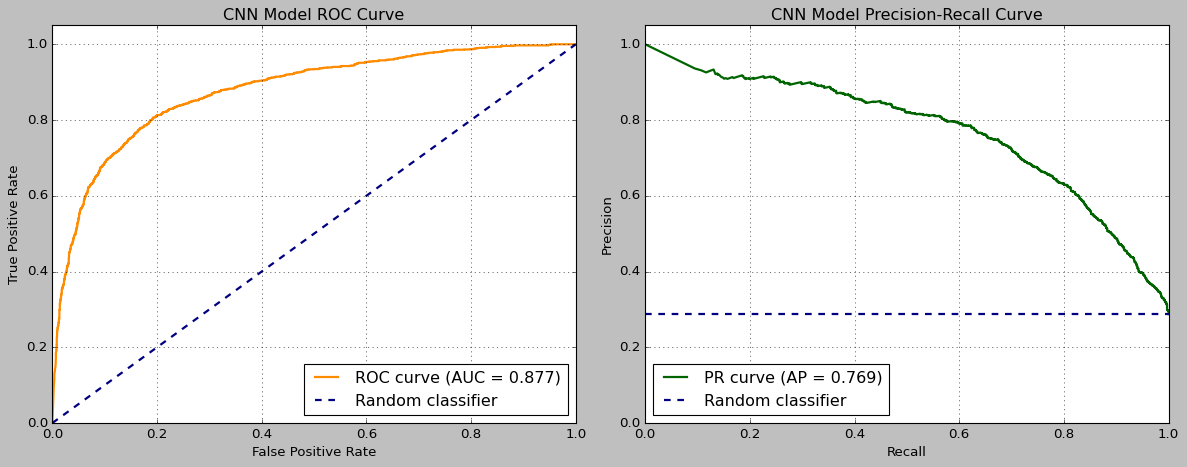

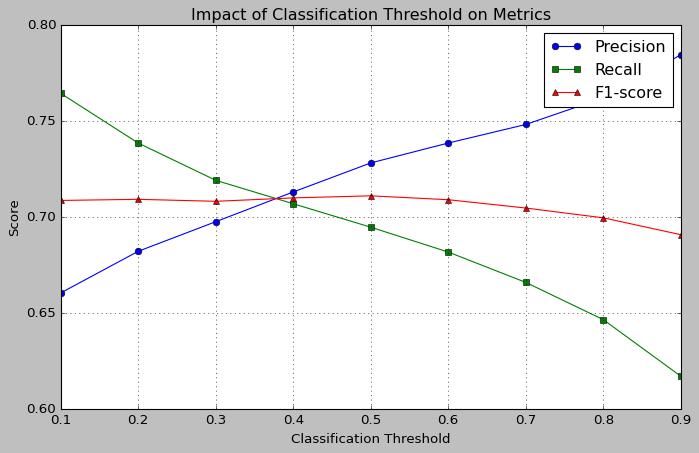


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8770

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7686

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.50
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.660, Recall=0.764, F1=0.709
   Threshold 0.2: Precision=0.682, Recall=0.739, F1=0.709
   Threshold 0.3: Precision=0.698, Recall=0.719, F1=0.708
   Threshold 0.4: Precision=0.713, Recall=0.707, F1=0.710
   Threshold 0.5: Precision=0.728, Recall=0.695, F1=0.711
   Threshold 0.6: Precision=0.739, Recall=0.682, F1=0.709
   Threshold 0.7: Precision=0.748, Recall=0.666, F1=0.705
   Threshold 0.8: Precision=0.762, Recall=0.647, F1=0.700
   Threshold 0.9: Precision=0.784, Recall=0.617, F1=0.691
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Cross-Validation Results:
Accuracy: 0.8970 ± 0.0048
Precision: 0.8901 ± 0.0102
Recall: 0.9063 ± 0.0150
F1: 0.8979 ± 0.0052

Test Set

In [35]:

# X_test = X_test.reshape(X_test.shape[0], 11, 9) 
# print("Original X_test shape:", X_test.shape)

roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
thres = find_optimal_threshold(threshold_results)

y_test_pred = (best_model.predict(X_test) > thres).astype(int)
test_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1': f1_score(y_test, y_test_pred)
}

print("\nCross-Validation Results:")
for metric in cv_scores:
    mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

print("\nTest Set Results (Best Model):")
for metric, value in test_metrics.items():
    print(f"{metric.title()}: {value:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_test_pred))
print("\nClassification Report (Imbalanced):")
print(classification_report_imbalanced(y_test, y_test_pred))



# CNN_lstm model : mu-sigma new

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training Set After apply_mu_sigma_new ====================
Dataset shape: (30102, 11, 9)
Labels shape: (30102,)

Class Distribution:
-----------------
Class 0: 13989 samples (46.47%)
Class 1: 16113 samples (53.53%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.7335 - loss: 0.4826 - val_accuracy: 0.8103 - val_loss: 0.3878
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.8151 - loss: 0.3740 - val_accuracy: 0.8118 - val_loss: 0.3852
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.8232 - loss: 0.3603 - val_accuracy: 0.8284 - val_loss: 0.3523
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.8319 - loss: 0.3512 - val_accuracy: 0.8248 - val_loss: 0.3489
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.8342 - loss: 0.3468 - val_accuracy: 0.8314 - val_loss: 0.3409
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.8411 - loss: 0.3307 - val_accuracy: 0.8196 - val_loss: 0.3574
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.8491 - loss: 0.3211 - val_accuracy: 0.8321 - val_loss: 0.3514
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.8556 - loss: 0

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.7317 - loss: 0.4883 - val_accuracy: 0.8256 - val_loss: 0.3604
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8176 - loss: 0.3729 - val_accuracy: 0.8117 - val_loss: 0.3689
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8261 - loss: 0.3554 - val_accuracy: 0.8188 - val_loss: 0.3608
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8281 - loss: 0.3525 - val_accuracy: 0.8333 - val_loss: 0.3381
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8394 - loss: 0.3379 - val_accuracy: 0.8323 - val_loss: 0.3390
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8447 - loss: 0.3237 - val_accuracy: 0.8440 - val_loss: 0.3276
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8466 - loss: 0.3212 - val_accuracy: 0.8412 - val_loss: 0.3325
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8559 - loss: 0.3033 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.7387 - loss: 0.4738 - val_accuracy: 0.8196 - val_loss: 0.3725
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8140 - loss: 0.3759 - val_accuracy: 0.8214 - val_loss: 0.3631
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8257 - loss: 0.3593 - val_accuracy: 0.8276 - val_loss: 0.3519
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8352 - loss: 0.3480 - val_accuracy: 0.8304 - val_loss: 0.3484
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8384 - loss: 0.3347 - val_accuracy: 0.8307 - val_loss: 0.3424
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8386 - loss: 0.3343 - val_accuracy: 0.8362 - val_loss: 0.3362
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8507 - loss: 0.3195 - val_accuracy: 0.8347 - val_loss: 0.3338
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8510 - loss: 0.3137 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7334 - loss: 0.4817 - val_accuracy: 0.8337 - val_loss: 0.3617
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8131 - loss: 0.3780 - val_accuracy: 0.8216 - val_loss: 0.3743
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8197 - loss: 0.3625 - val_accuracy: 0.8365 - val_loss: 0.3478
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8278 - loss: 0.3482 - val_accuracy: 0.8384 - val_loss: 0.3415
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8362 - loss: 0.3409 - val_accuracy: 0.8352 - val_loss: 0.3471
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8345 - loss: 0.3387 - val_accuracy: 0.8399 - val_loss: 0.3341
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8475 - loss: 0.3196 - val_accuracy: 0.8360 - val_loss: 0.3379
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8512 - loss: 0.3132 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 56s 42ms/step - accuracy: 0.7196 - loss: 0.4890 - val_accuracy: 0.8113 - val_loss: 0.3763
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.8198 - loss: 0.3708 - val_accuracy: 0.8251 - val_loss: 0.3602
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.8294 - loss: 0.3563 - val_accuracy: 0.8277 - val_loss: 0.3490
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.8305 - loss: 0.3493 - val_accuracy: 0.7894 - val_loss: 0.3935
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.8407 - loss: 0.3357 - val_accuracy: 0.8279 - val_loss: 0.3434
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.8401 - loss: 0.3372 - val_accuracy: 0.8332 - val_loss: 0.3429
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.8526 - loss: 0.3164 - val_accuracy: 0.8289 - val_loss: 0.3395
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.8552 - loss: 0

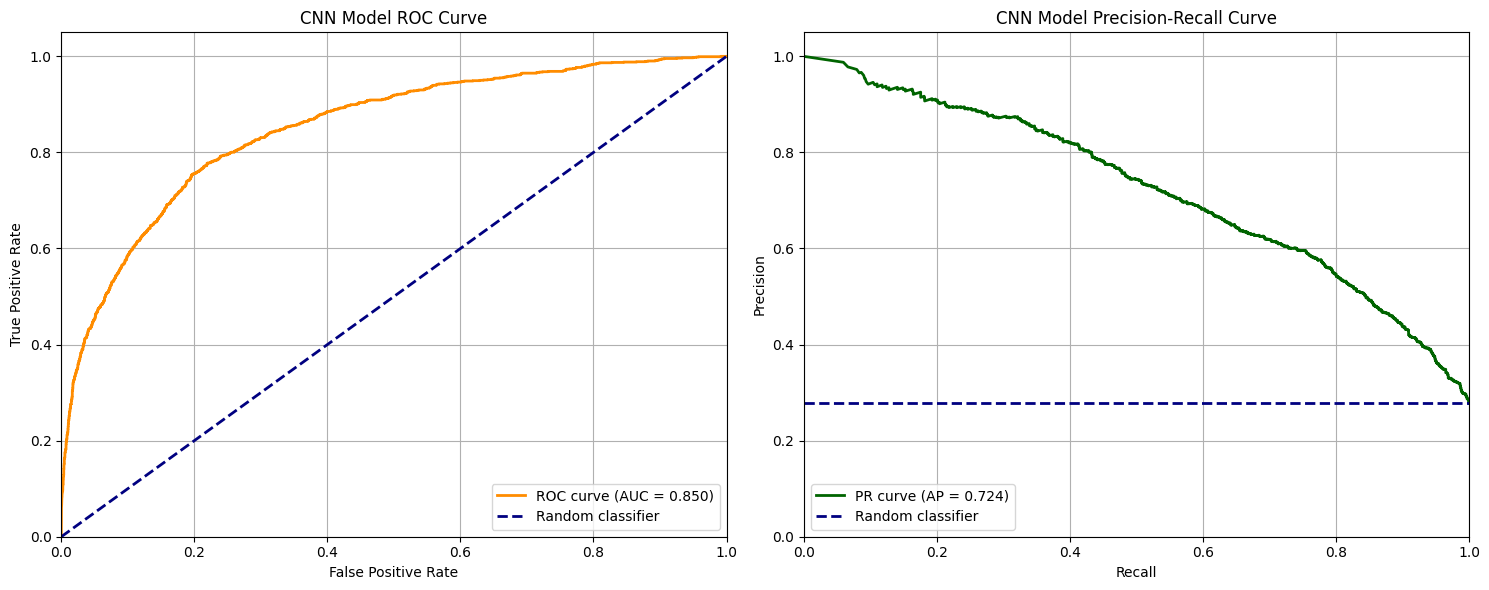

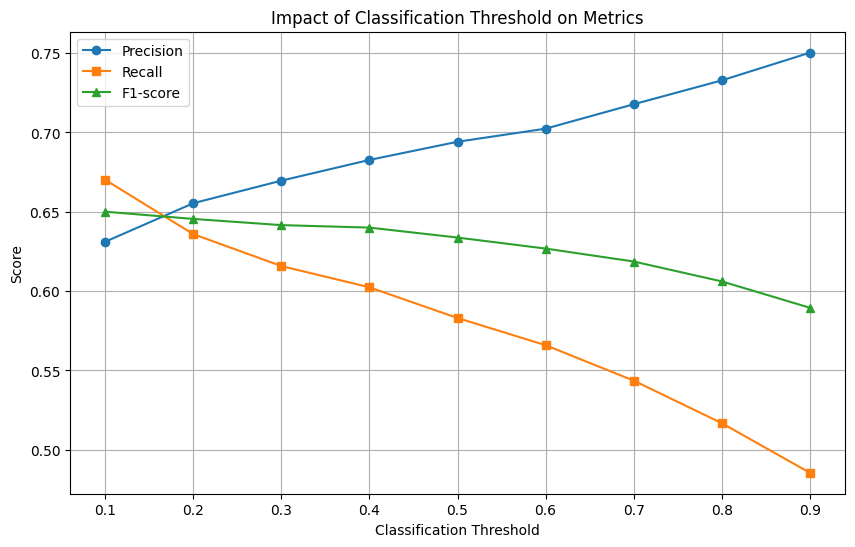


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8496

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7236

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.10
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.631, Recall=0.670, F1=0.650
   Threshold 0.2: Precision=0.655, Recall=0.636, F1=0.646
   Threshold 0.3: Precision=0.670, Recall=0.616, F1=0.642
   Threshold 0.4: Precision=0.683, Recall=0.602, F1=0.640
   Threshold 0.5: Precision=0.694, Recall=0.583, F1=0.634
   Threshold 0.6: Precision=0.702, Recall=0.566, F1=0.627
   Threshold 0.7: Precision=0.718, Recall=0.544, F1=0.619
   Threshold 0.8: Precision=0.733, Recall=0.517, F1=0.606
   Threshold 0.9: Precision=0.750, Recall=0.485, F1=0.590
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Cross-Validation Results:
Accuracy: 0.8816 ± 0.0037
Precision: 0.8993 ± 0.0099
Recall: 0.8773 ± 0.0065
F1: 0.8881 ± 0.0028

Test Set

ValueError: not enough values to unpack (expected 6, got 4)

In [5]:
cv_scores_ms2, test_scores_ms2, best_cnn_model_ms2, history_model_ms2, y_test_model2, y_test_pred_model2 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, augmentation_fn=apply_mu_sigma_new, 
    window_size=11, step_size=1
)

# cnn-lstm model - NONE

In [ ]:
cv_scores_n, test_scores_n, best_cnn_model_n, history_model_n, y_test_modeln, y_test_pred_modeln = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, augmentation_fn=None, 
    window_size=11, step_size=1
)
# plot_performance(cnn_lstm_history)

# cnn-lstm : SMOTE

In [ ]:
cv_scores_n, test_scores_n, best_cnn_model_n, history_model_n, y_test_modeln, y_test_pred_modeln = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, augmentation_fn=apply_adasyn, 
    window_size=11, step_size=1
)

# cnn-lstm ros 

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after SMOTE: 27978 samples

==================== Training Set After apply_smote ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5
Epoch 1/100


/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6032 - loss: 0.6615 - val_accuracy: 0.6578 - val_loss: 0.6128
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6765 - loss: 0.6007 - val_accuracy: 0.6901 - val_loss: 0.5773
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7196 - loss: 0.5500 - val_accuracy: 0.7332 - val_loss: 0.5252
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7614 - loss: 0.4949 - val_accuracy: 0.7570 - val_loss: 0.5008
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7916 - loss: 0.4432 - val_accuracy: 0.7979 - val_loss: 0.4430
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8180 - loss: 0.4042 - val_accuracy: 0.8159 - val_loss: 0.4135
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8496 - loss: 0.3478 - val_accuracy: 0.8154 - val_loss: 0.4054
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8630 - loss: 0.3207 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5984 - loss: 0.6624 - val_accuracy: 0.6741 - val_loss: 0.6086
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6774 - loss: 0.6046 - val_accuracy: 0.6996 - val_loss: 0.5721
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.7147 - loss: 0.5590 - val_accuracy: 0.7312 - val_loss: 0.5352
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7514 - loss: 0.5050 - val_accuracy: 0.7588 - val_loss: 0.4963
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7854 - loss: 0.4516 - val_accuracy: 0.7782 - val_loss: 0.4551
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8144 - loss: 0.4077 - val_accuracy: 0.8033 - val_loss: 0.4234
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8415 - loss: 0.3623 - val_accuracy: 0.8175 - val_loss: 0.4078
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8587 - loss: 0.3279 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6046 - loss: 0.6569 - val_accuracy: 0.6673 - val_loss: 0.6100
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6766 - loss: 0.6007 - val_accuracy: 0.7003 - val_loss: 0.5761
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7145 - loss: 0.5578 - val_accuracy: 0.7291 - val_loss: 0.5338
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7525 - loss: 0.5062 - val_accuracy: 0.7588 - val_loss: 0.4947
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.7907 - loss: 0.4517 - val_accuracy: 0.7859 - val_loss: 0.4587
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8187 - loss: 0.3994 - val_accuracy: 0.7954 - val_loss: 0.4365
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8387 - loss: 0.3672 - val_accuracy: 0.8029 - val_loss: 0.4280
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8609 - loss: 0.3235 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.6045 - loss: 0.6592 - val_accuracy: 0.6601 - val_loss: 0.6177
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6833 - loss: 0.5960 - val_accuracy: 0.7137 - val_loss: 0.5608
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.7252 - loss: 0.5462 - val_accuracy: 0.7487 - val_loss: 0.5171
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.7648 - loss: 0.4947 - val_accuracy: 0.7705 - val_loss: 0.4824
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.7938 - loss: 0.4431 - val_accuracy: 0.7889 - val_loss: 0.4467
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8188 - loss: 0.3998 - val_accuracy: 0.7973 - val_loss: 0.4406
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8394 - loss: 0.3625 - val_accuracy: 0.8073 - val_loss: 0.4293
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8569 - loss: 0.3285 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.6093 - loss: 0.6572 - val_accuracy: 0.6626 - val_loss: 0.6166
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6796 - loss: 0.5995 - val_accuracy: 0.6917 - val_loss: 0.5822
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7164 - loss: 0.5544 - val_accuracy: 0.7167 - val_loss: 0.5574
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7467 - loss: 0.5122 - val_accuracy: 0.7612 - val_loss: 0.4952
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7876 - loss: 0.4546 - val_accuracy: 0.7791 - val_loss: 0.4725
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8106 - loss: 0.4115 - val_accuracy: 0.7916 - val_loss: 0.4488
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8419 - loss: 0.3630 - val_accuracy: 0.8148 - val_loss: 0.4159
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8596 - loss: 0.3258 - val_

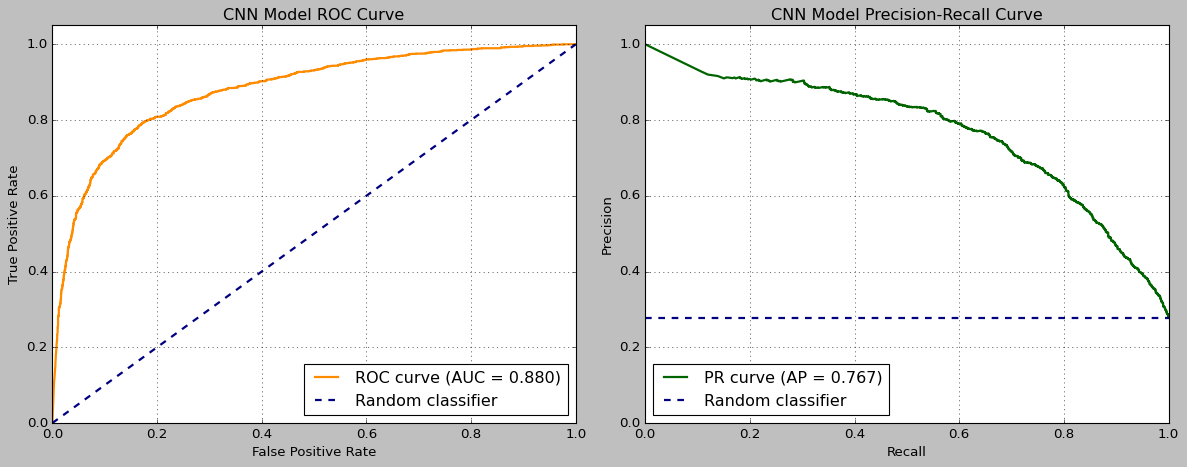

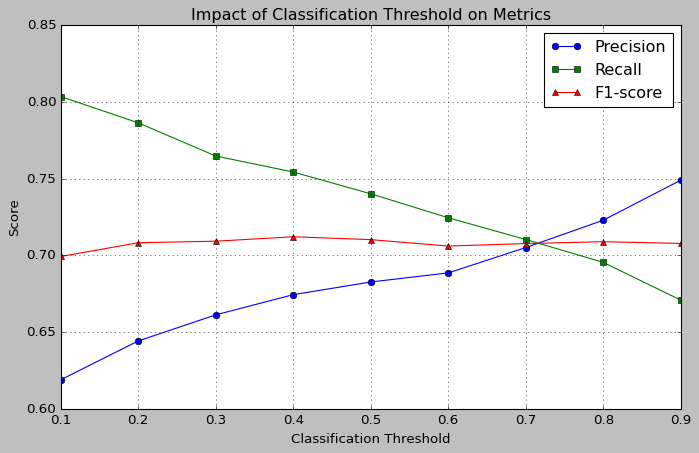


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8796

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7671

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.619, Recall=0.803, F1=0.699
   Threshold 0.2: Precision=0.644, Recall=0.786, F1=0.708
   Threshold 0.3: Precision=0.661, Recall=0.765, F1=0.709
   Threshold 0.4: Precision=0.674, Recall=0.754, F1=0.712
   Threshold 0.5: Precision=0.683, Recall=0.740, F1=0.710
   Threshold 0.6: Precision=0.689, Recall=0.724, F1=0.706
   Threshold 0.7: Precision=0.705, Recall=0.710, F1=0.708
   Threshold 0.8: Precision=0.723, Recall=0.695, F1=0.709
   Threshold 0.9: Precision=0.749, Recall=0.671, F1=0.708
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Cross-Validation Results:
Accuracy: 0.8969 ± 0.0024
Precision: 0.8839 ± 0.0100
Recall: 0.9141 ± 0.0101
F1: 0.8987 ± 0.0019

Test Set

In [59]:
# build_cnn_lstm_hybrid_model_5 -> better [done]
# smote , cnn 64 units 
cv_scores, test_metrics, best_model, history = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, augmentation_fn=apply_smote, 
    window_size=11, step_size=1
)

plot_model(best_model, show_shape=True)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after ROS: 27978 samples

==================== Training Set After apply_ros ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.5999 - loss: 0.6617 - val_accuracy: 0.6776 - val_loss: 0.6069
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6737 - loss: 0.6110 - val_accuracy: 0.6878 - val_loss: 0.5946
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.6784 - loss: 0.5963 - val_accuracy: 0.7043 - val_loss: 0.5725
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7055 - loss: 0.5628 - val_accuracy: 0.7241 - val_loss: 0.5452
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7371 - loss: 0.5211 - val_accuracy: 0.7452 - val_loss: 0.5137
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7722 - loss: 0.4698 - val_accuracy: 0.7664 - val_loss: 0.4767
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8121 - loss: 0.4131 - val_accuracy: 0.7848 - val_loss: 0.4536
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8451 - loss: 0

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6102 - loss: 0.6550 - val_accuracy: 0.6690 - val_loss: 0.6113
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6720 - loss: 0.6097 - val_accuracy: 0.6733 - val_loss: 0.6015
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6929 - loss: 0.5826 - val_accuracy: 0.6932 - val_loss: 0.5801
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7080 - loss: 0.5572 - val_accuracy: 0.7085 - val_loss: 0.5579
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7371 - loss: 0.5184 - val_accuracy: 0.7339 - val_loss: 0.5225
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7632 - loss: 0.4846 - val_accuracy: 0.7489 - val_loss: 0.4951
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7989 - loss: 0.4311 - val_accuracy: 0.7863 - val_loss: 0.4561
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8251 - loss: 0.3823 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6153 - loss: 0.6562 - val_accuracy: 0.6639 - val_loss: 0.6135
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6708 - loss: 0.6065 - val_accuracy: 0.6724 - val_loss: 0.6001
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6911 - loss: 0.5856 - val_accuracy: 0.6950 - val_loss: 0.5740
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7069 - loss: 0.5634 - val_accuracy: 0.7114 - val_loss: 0.5467
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7331 - loss: 0.5232 - val_accuracy: 0.7341 - val_loss: 0.5225
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7706 - loss: 0.4736 - val_accuracy: 0.7650 - val_loss: 0.4853
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8092 - loss: 0.4198 - val_accuracy: 0.7954 - val_loss: 0.4450
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.8402 - loss: 0.3631 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6124 - loss: 0.6559 - val_accuracy: 0.6783 - val_loss: 0.6125
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6670 - loss: 0.6118 - val_accuracy: 0.6912 - val_loss: 0.5942
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6931 - loss: 0.5831 - val_accuracy: 0.7046 - val_loss: 0.5684
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7120 - loss: 0.5518 - val_accuracy: 0.7185 - val_loss: 0.5453
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7459 - loss: 0.5036 - val_accuracy: 0.7451 - val_loss: 0.5148
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7737 - loss: 0.4633 - val_accuracy: 0.7664 - val_loss: 0.4820
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8146 - loss: 0.4053 - val_accuracy: 0.7882 - val_loss: 0.4470
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8423 - loss: 0.3544 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6079 - loss: 0.6554 - val_accuracy: 0.6601 - val_loss: 0.6184
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6770 - loss: 0.6065 - val_accuracy: 0.6752 - val_loss: 0.6067
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6930 - loss: 0.5805 - val_accuracy: 0.6926 - val_loss: 0.5894
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7140 - loss: 0.5558 - val_accuracy: 0.7158 - val_loss: 0.5567
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7533 - loss: 0.5015 - val_accuracy: 0.7428 - val_loss: 0.5134
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7897 - loss: 0.4462 - val_accuracy: 0.7648 - val_loss: 0.4781
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8230 - loss: 0.3937 - val_accuracy: 0.7959 - val_loss: 0.4485
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8553 - loss: 0.3393 - val_

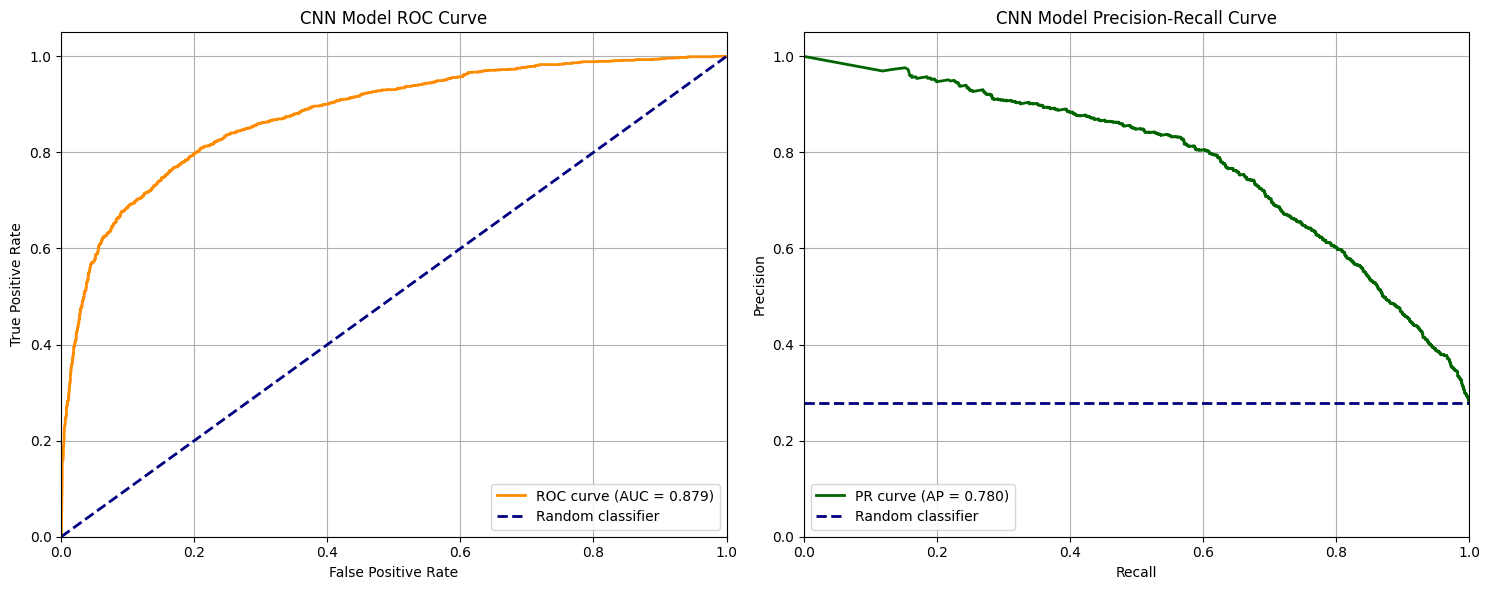

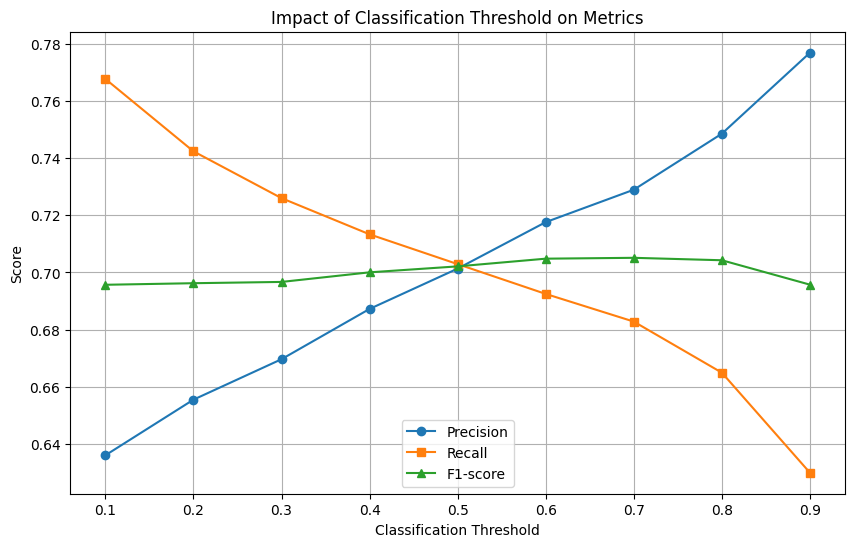


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8789

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7800

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.70
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.636, Recall=0.768, F1=0.696
   Threshold 0.2: Precision=0.655, Recall=0.742, F1=0.696
   Threshold 0.3: Precision=0.670, Recall=0.726, F1=0.697
   Threshold 0.4: Precision=0.687, Recall=0.713, F1=0.700
   Threshold 0.5: Precision=0.701, Recall=0.703, F1=0.702
   Threshold 0.6: Precision=0.718, Recall=0.692, F1=0.705
   Threshold 0.7: Precision=0.729, Recall=0.683, F1=0.705
   Threshold 0.8: Precision=0.749, Recall=0.665, F1=0.704
   Threshold 0.9: Precision=0.777, Recall=0.630, F1=0.696
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Cross-Validation Results:
Accuracy: 0.9168 ± 0.0050
Precision: 0.8908 ± 0.0054
Recall: 0.9502 ± 0.0056
F1: 0.9195 ± 0.0048

Test Set

In [7]:
# ROS 
cv_scores, test_metrics, best_model, cnn_lstm_history = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, 
    augmentation_fn=apply_ros, 
    window_size=11, step_size=1
)

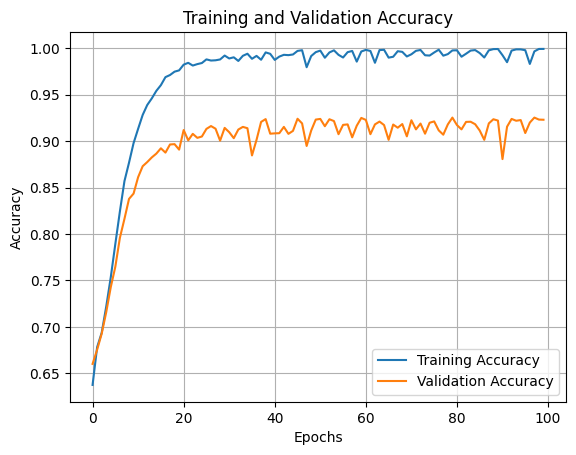

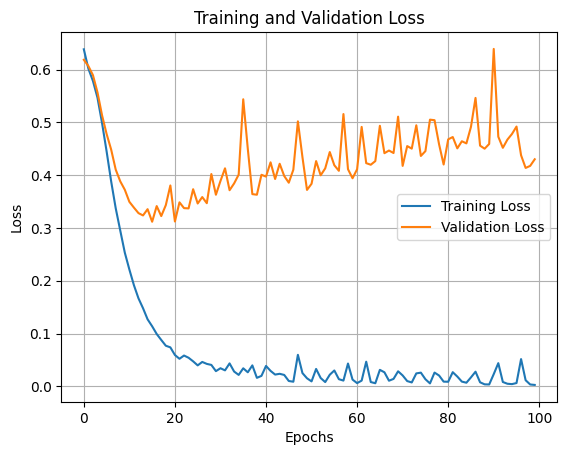

In [8]:
def plot_accuracy(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plt.style.use('default')

plot_accuracy(cnn_lstm_history)
plot_loss(cnn_lstm_history)

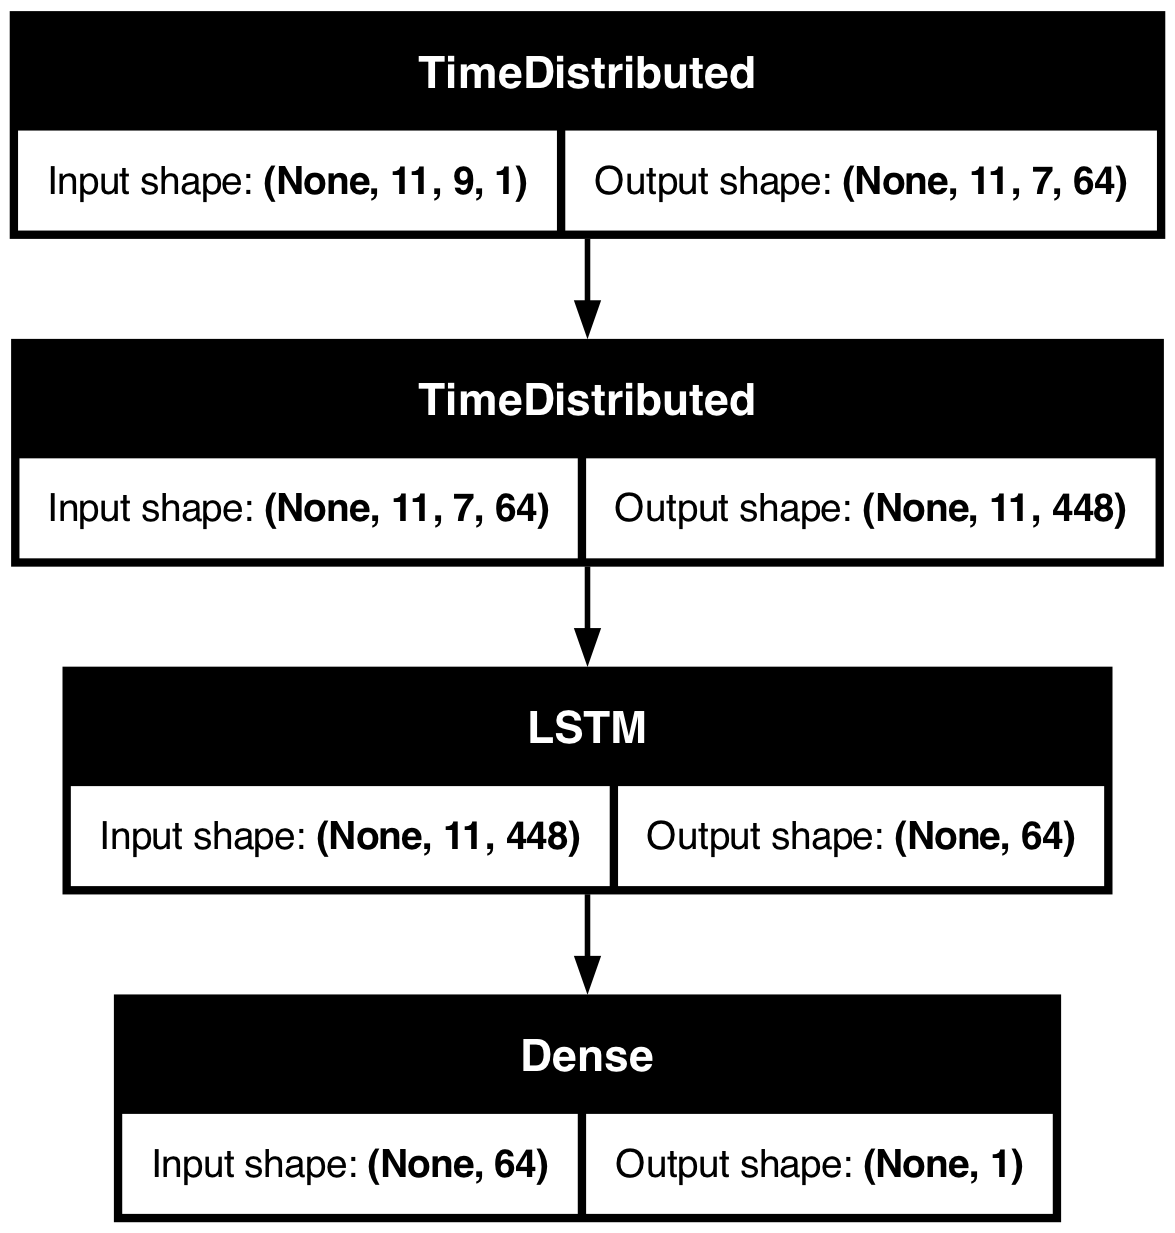

In [16]:
plot_model(best_model, show_shapes=True)

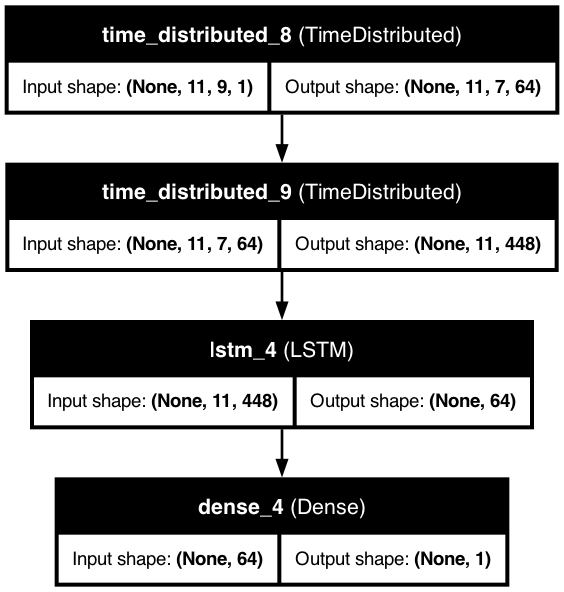

In [14]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already created
plot_model(best_model, to_file='cnnlstm-arch.png', 
           show_shapes=True, 
           show_layer_names=True, 
           rankdir='TB', 
           dpi=96)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after ADASYN: 26965 samples

==================== Training Set After apply_adasyn ====================
Dataset shape: (26965, 11, 9)
Labels shape: (26965,)

Class Distribution:
-----------------
Class 0: 14038 samples (52.06%)
Class 1: 12927 samples (47.94%)

Fold 1/5
Epoch 1/100


/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5857 - loss: 0.6686 - val_accuracy: 0.6379 - val_loss: 0.6336
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6528 - loss: 0.6193 - val_accuracy: 0.6651 - val_loss: 0.6150
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7055 - loss: 0.5725 - val_accuracy: 0.7308 - val_loss: 0.5379
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7400 - loss: 0.5167 - val_accuracy: 0.7302 - val_loss: 0.5302
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7763 - loss: 0.4760 - val_accuracy: 0.7636 - val_loss: 0.4861
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8027 - loss: 0.4265 - val_accuracy: 0.7851 - val_loss: 0.4515
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8272 - loss: 0.3869 - val_accuracy: 0.7760 - val_loss: 0.4651
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8481 - loss: 0.3445 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5948 - loss: 0.6641 - val_accuracy: 0.6340 - val_loss: 0.6356
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6557 - loss: 0.6174 - val_accuracy: 0.6705 - val_loss: 0.6028
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6908 - loss: 0.5757 - val_accuracy: 0.7083 - val_loss: 0.5603
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7317 - loss: 0.5291 - val_accuracy: 0.7335 - val_loss: 0.5230
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7695 - loss: 0.4821 - val_accuracy: 0.7697 - val_loss: 0.4805
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8021 - loss: 0.4272 - val_accuracy: 0.7675 - val_loss: 0.4736
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8270 - loss: 0.3825 - val_accuracy: 0.8001 - val_loss: 0.4256
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8501 - loss: 0.3405 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5790 - loss: 0.6698 - val_accuracy: 0.6453 - val_loss: 0.6273
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6499 - loss: 0.6266 - val_accuracy: 0.6751 - val_loss: 0.5994
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6883 - loss: 0.5873 - val_accuracy: 0.7046 - val_loss: 0.5650
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7310 - loss: 0.5355 - val_accuracy: 0.7343 - val_loss: 0.5180
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7551 - loss: 0.4960 - val_accuracy: 0.7675 - val_loss: 0.4837
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7920 - loss: 0.4372 - val_accuracy: 0.7844 - val_loss: 0.4535
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8155 - loss: 0.3985 - val_accuracy: 0.7760 - val_loss: 0.4682
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8372 - loss: 0.3642 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5816 - loss: 0.6702 - val_accuracy: 0.6546 - val_loss: 0.6230
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6530 - loss: 0.6226 - val_accuracy: 0.6976 - val_loss: 0.5812
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6952 - loss: 0.5824 - val_accuracy: 0.7308 - val_loss: 0.5325
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7310 - loss: 0.5355 - val_accuracy: 0.7521 - val_loss: 0.5107
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7677 - loss: 0.4827 - val_accuracy: 0.7823 - val_loss: 0.4763
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7921 - loss: 0.4438 - val_accuracy: 0.7938 - val_loss: 0.4531
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8199 - loss: 0.3937 - val_accuracy: 0.8096 - val_loss: 0.4192
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8383 - loss: 0.3587 - val_a

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5826 - loss: 0.6701 - val_accuracy: 0.6147 - val_loss: 0.6600
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6470 - loss: 0.6253 - val_accuracy: 0.6755 - val_loss: 0.6001
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.6833 - loss: 0.5879 - val_accuracy: 0.7169 - val_loss: 0.5527
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.7291 - loss: 0.5363 - val_accuracy: 0.7384 - val_loss: 0.5215
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7633 - loss: 0.4902 - val_accuracy: 0.7326 - val_loss: 0.5304
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7896 - loss: 0.4465 - val_accuracy: 0.7665 - val_loss: 0.4746
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8097 - loss: 0.4098 - val_accuracy: 0.7951 - val_loss: 0.4329
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.8385 - loss: 0.3636 - val_

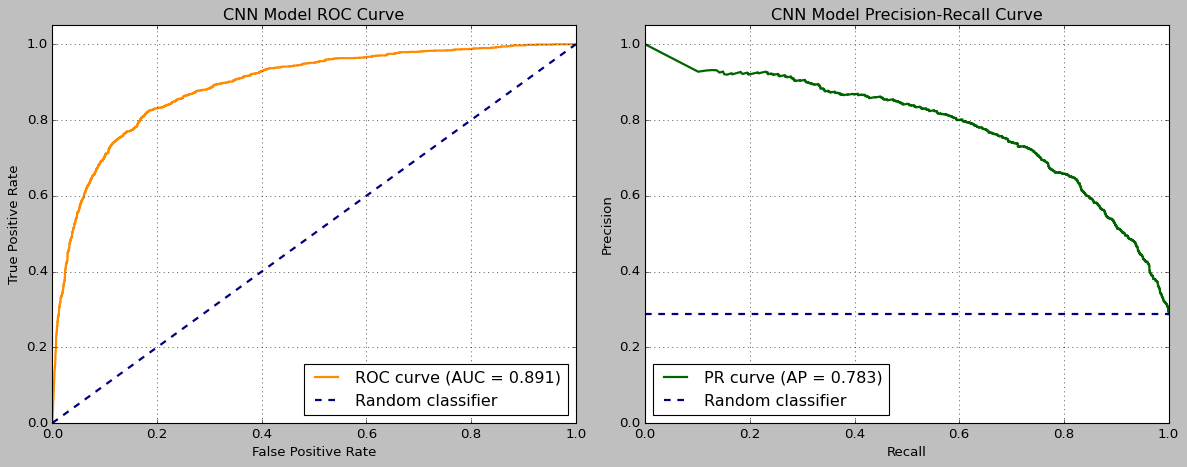

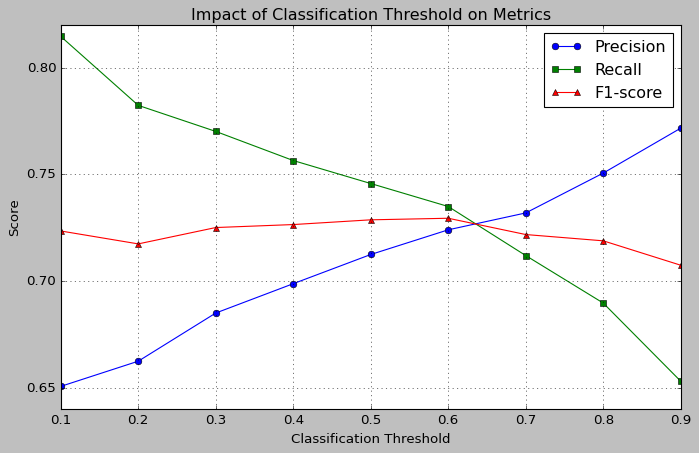


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8906

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7834

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.60
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.651, Recall=0.815, F1=0.723
   Threshold 0.2: Precision=0.662, Recall=0.782, F1=0.717
   Threshold 0.3: Precision=0.685, Recall=0.770, F1=0.725
   Threshold 0.4: Precision=0.699, Recall=0.756, F1=0.726
   Threshold 0.5: Precision=0.712, Recall=0.746, F1=0.729
   Threshold 0.6: Precision=0.724, Recall=0.735, F1=0.729
   Threshold 0.7: Precision=0.732, Recall=0.712, F1=0.722
   Threshold 0.8: Precision=0.751, Recall=0.690, F1=0.719
   Threshold 0.9: Precision=0.772, Recall=0.653, F1=0.707
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Cross-Validation Results:
Accuracy: 0.8942 ± 0.0030
Precision: 0.8824 ± 0.0094
Recall: 0.8994 ± 0.0181
F1: 0.8907 ± 0.0045

Test Set

In [41]:
# ADASYN
cv_scores, test_metrics, best_model, history = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, 
    augmentation_fn=apply_adasyn, 
    window_size=11, step_size=1
)

In [ ]:
# smote and mu-sigma
cv_scores, test_metrics, best_model, history = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, 
    augmentation_fn=apply_smote, second_aug_fn=apply_mu_sigma, 
    window_size=11, step_size=1
)

In [53]:
import torch 
import torch.nn as nn
import numpy as np

def apply_gan_augmentation(X_train, y_train, num_samples=8716, noise_dim=100, hidden_dim=64, num_epochs=500):
    """
    Generate synthetic time-series data using a GAN and augment the training set.
    
    Parameters:
    - X_train: Original training data (features)
    - y_train: Original training labels
    - num_samples: Number of synthetic sequences to generate
    - noise_dim: Dimensionality of the random noise vector
    - hidden_dim: Hidden layer size for both Generator and Discriminator
    - num_epochs: Number of epochs to train the GAN
    
    Returns:
    - X_augmented: Augmented feature set (X_train + synthetic samples)
    - y_augmented: Augmented labels set (y_train + synthetic labels)
    """

    # Get sequence length from X_train (assume [n_samples, seq_len, features])
    seq_len = X_train.shape[1]
    feature_dim = X_train.shape[2]

    # Define the Generator
    class Generator(nn.Module):
        def __init__(self, noise_dim, hidden_dim, output_dim):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(noise_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, noise):
            return self.model(noise)

    # Define the Discriminator
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )

        def forward(self, data):
            return self.model(data)

    # Initialize the Generator and Discriminator
    generator = Generator(noise_dim, hidden_dim, seq_len * feature_dim)
    discriminator = Discriminator(seq_len * feature_dim, hidden_dim)

    # Optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Function to generate random noise
    def generate_noise(batch_size, noise_dim):
        return torch.randn(batch_size, noise_dim)

    # Train the GAN
    batch_size = 32
    for epoch in range(num_epochs):
        # === Train Discriminator ===
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = torch.tensor(X_train[idx].reshape(batch_size, -1), dtype=torch.float32)
        fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        d_loss_real = criterion(discriminator(real_data), real_labels)
        d_loss_fake = criterion(discriminator(fake_data), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        noise = generate_noise(batch_size, noise_dim)
        generated_data = generator(noise)

        g_loss = criterion(discriminator(generated_data), real_labels)  # Fool the discriminator

        # Backprop for Generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate synthetic data
    noise = generate_noise(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()
    synthetic_data = synthetic_data.reshape(num_samples, seq_len, feature_dim)

    # Create synthetic labels (1 for falls or any minority class, as needed)
    synthetic_labels = np.ones(num_samples)

    # Concatenate synthetic data with original training data
    X_augmented = np.concatenate((X_train, synthetic_data), axis=0)
    y_augmented = np.concatenate((y_train, synthetic_labels), axis=0)

    return X_augmented, y_augmented

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Epoch [0/500] | D Loss: 1.3455 | G Loss: 0.6345
Epoch [100/500] | D Loss: 1.3333 | G Loss: 0.6314
Epoch [200/500] | D Loss: 1.2778 | G Loss: 0.6747
Epoch [300/500] | D Loss: 1.2481 | G Loss: 0.6666
Epoch [400/500] | D Loss: 1.0769 | G Loss: 0.7352

==================== Training Set After GAN Aug: apply_gan_augmentation ====================
Dataset shape: (28076, 11, 9)
Labels shape: (28076,)

Class Distribution:
-----------------
Class 0.0: 13989 samples (49.83%)
Class 1.0: 14087 samples (50.17%)

Fold 1/5


/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.7883 - loss: 0.4333 - val_accuracy: 0.8180 - val_loss: 0.3784
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8169 - loss: 0.3757 - val_accuracy: 0.8157 - val_loss: 0.3758
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8226 - loss: 0.3666 - val_accuracy: 0.8178 - val_loss: 0.3732
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8273 - loss: 0.3592 - val_accuracy: 0.8223 - val_loss: 0.3652
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8380 - loss: 0.3434 - val_accuracy: 0.8371 - val_loss: 0.3493
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8416 - loss: 0.3389 - val_accuracy: 0.8389 - val_loss: 0.3471
Epoch 7/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8486 - loss: 0.3262 - val_accuracy: 0.8415 - val_loss: 0.3364
Epoch 8/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8597 - loss: 0

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


702/702 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7887 - loss: 0.4303 - val_accuracy: 0.8151 - val_loss: 0.3738
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8172 - loss: 0.3762 - val_accuracy: 0.8230 - val_loss: 0.3659
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8245 - loss: 0.3616 - val_accuracy: 0.8249 - val_loss: 0.3593
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8335 - loss: 0.3536 - val_accuracy: 0.8267 - val_loss: 0.3540
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8342 - loss: 0.3441 - val_accuracy: 0.8315 - val_loss: 0.3476
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8385 - loss: 0.3384 - val_accuracy: 0.8280 - val_loss: 0.3550
Epoch 7/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8518 - loss: 0.3220 - val_accuracy: 0.8443 - val_loss: 0.3339
Epoch 8/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8564 - loss: 0.3137 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


702/702 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.7999 - loss: 0.4251 - val_accuracy: 0.8105 - val_loss: 0.3763
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.8146 - loss: 0.3779 - val_accuracy: 0.8207 - val_loss: 0.3682
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8254 - loss: 0.3644 - val_accuracy: 0.8283 - val_loss: 0.3547
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8330 - loss: 0.3501 - val_accuracy: 0.8283 - val_loss: 0.3526
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8393 - loss: 0.3456 - val_accuracy: 0.8233 - val_loss: 0.3544
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8469 - loss: 0.3335 - val_accuracy: 0.8381 - val_loss: 0.3444
Epoch 7/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.8533 - loss: 0.3217 - val_accuracy: 0.8344 - val_loss: 0.3444
Epoch 8/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8570 - loss: 0.3114 - val_

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 96s 125ms/step - accuracy: 0.8003 - loss: 0.4244 - val_accuracy: 0.8148 - val_loss: 0.3828
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8197 - loss: 0.3715 - val_accuracy: 0.8148 - val_loss: 0.3819
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8250 - loss: 0.3602 - val_accuracy: 0.8223 - val_loss: 0.3689
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8316 - loss: 0.3509 - val_accuracy: 0.8255 - val_loss: 0.3635
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.8366 - loss: 0.3406 - val_accuracy: 0.8353 - val_loss: 0.3558
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8470 - loss: 0.3300 - val_accuracy: 0.8379 - val_loss: 0.3479
Epoch 7/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8570 - loss: 0.3150 - val_accuracy: 0.8324 - val_loss: 0.3446
Epoch 8/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8649 - loss: 

/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.7816 - loss: 0.4338 - val_accuracy: 0.8212 - val_loss: 0.3776
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.8221 - loss: 0.3724 - val_accuracy: 0.8274 - val_loss: 0.3616
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.8292 - loss: 0.3567 - val_accuracy: 0.8308 - val_loss: 0.3554
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.8263 - loss: 0.3587 - val_accuracy: 0.8353 - val_loss: 0.3491
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8426 - loss: 0.3385 - val_accuracy: 0.8338 - val_loss: 0.3457
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8496 - loss: 0.3304 - val_accuracy: 0.8328 - val_loss: 0.3430
Epoch 7/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8483 - loss: 0.3268 - val_accuracy: 0.8395 - val_loss: 0.3371
Epoch 8/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8600 - loss: 0

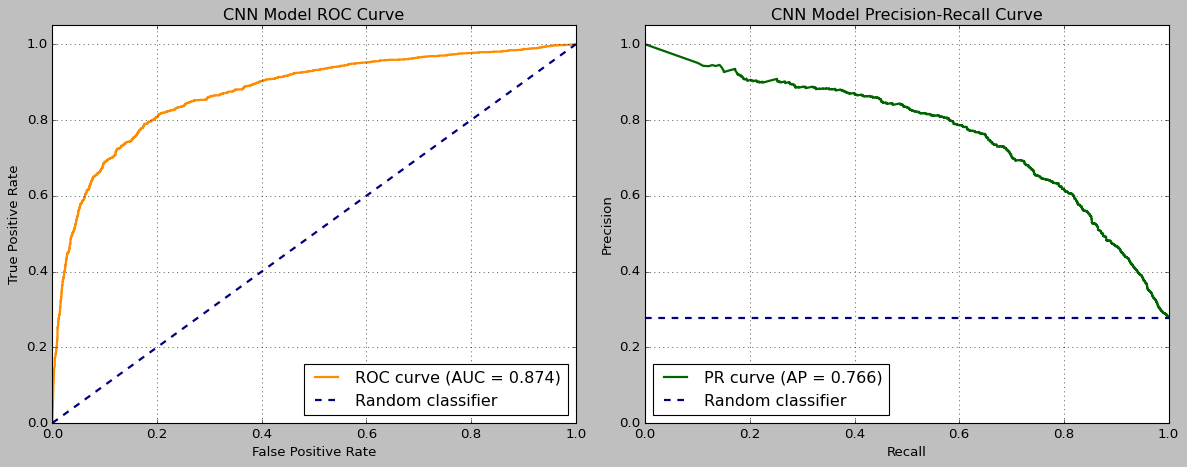

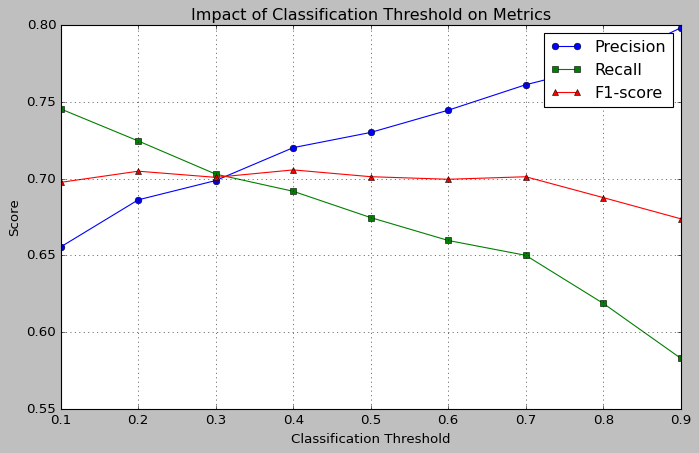


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8737

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7658

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.656, Recall=0.745, F1=0.698
   Threshold 0.2: Precision=0.686, Recall=0.724, F1=0.705
   Threshold 0.3: Precision=0.699, Recall=0.703, F1=0.701
   Threshold 0.4: Precision=0.720, Recall=0.692, F1=0.706
   Threshold 0.5: Precision=0.730, Recall=0.675, F1=0.701
   Threshold 0.6: Precision=0.745, Recall=0.660, F1=0.700
   Threshold 0.7: Precision=0.761, Recall=0.650, F1=0.701
   Threshold 0.8: Precision=0.774, Recall=0.619, F1=0.688
   Threshold 0.9: Precision=0.798, Recall=0.583, F1=0.674
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Cross-Validation Results:
Accuracy: 0.8858 ± 0.0036
Precision: 0.9006 ± 0.0042
Recall: 0.8683 ± 0.0093
F1: 0.8841 ± 0.0041

Test Set

In [60]:
cv_scores, test_metrics, best_model, history = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, 
    augmentation_fn=None, gan_fn=apply_gan_augmentation,
    window_size=11, step_size=1
)

In [6]:
# apply t-smote
# minority = falls (1)
import numpy as np
from sklearn.neighbors import NearestNeighbors

def t_smote_3d(X, y, minority_class_label=1, target_ratio=1.0, n_neighbors=5, beta=0.5):
    """
    T-SMOTE implementation for 3D time-series data with manual minority class definition.

    Args:
        X (numpy.ndarray): Feature matrix (n_samples, time_steps, n_features).
        y (numpy.ndarray): Labels.
        minority_class_label (int): Label of the minority class to be oversampled.
        n_neighbors (int): Number of temporal neighbors.
        beta (float): Beta distribution parameter for interpolation.

    Returns:
        X_new, y_new: Resampled feature matrix and labels.
    """
    n_samples, time_steps, n_features = X.shape

    # Reshape to 2D: (n_samples, time_steps * n_features)
    X_reshaped = X.reshape(n_samples, -1)

    # Select minority class samples
    X_minority = X_reshaped[y == minority_class_label]
    X_majority = X_reshaped[y != minority_class_label] # class 0

    n_minority = X_minority.shape[0]
    n_majority = X_majority.shape[0]

    # Calculate the number of synthetic samples needed
    n_synthetic = int(n_majority * target_ratio - n_minority)
    if n_synthetic <= 0:
        print("No oversampling needed. Returning original dataset.")
        return X, y

    # Adjust n_neighbors if needed
    n_neighbors = min(n_neighbors, n_minority - 1)
    temporal_neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(X_minority)

    # Generate synthetic samples
    X_synthetic = []
    for _ in range(n_synthetic):
        # Randomly select a minority sample and find its neighbors
        idx = np.random.randint(0, n_minority)
        neighbors = temporal_neighbors.kneighbors([X_minority[idx]], return_distance=False)[0]
        neighbor = X_minority[np.random.choice(neighbors)]

        # Interpolate between the selected sample and its neighbor
        alpha = np.random.beta(beta, 1 - beta)
        synthetic = alpha * X_minority[idx] + (1 - alpha) * neighbor
        X_synthetic.append(synthetic)


    X_synthetic = np.array(X_synthetic)
    # Reshape synthetic samples back to 3D
    X_synthetic_3d = X_synthetic.reshape(-1, time_steps, n_features)
    # Create labels for synthetic samples
    y_synthetic = np.full(X_synthetic_3d.shape[0], minority_class_label)
    # Combine original and synthetic data
    X_resampled = np.vstack((X, X_synthetic_3d))
    y_resampled = np.hstack((y, y_synthetic))
    return X_resampled, y_resampled


cv_scores_tsmote, test_scores_tsmote, best_cnn_model_tsmote, history_model_tsmote = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_lstm_hybrid_model_5, augmentation_fn=t_smote_3d, 
    window_size=11, step_size=1
)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training Set After t_smote_3d ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5


/Users/mivspaningbatan/Desktop/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 51s 48ms/step - accuracy: 0.6038 - loss: 0.6616 - val_accuracy: 0.6667 - val_loss: 0.6182
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.6614 - loss: 0.6147 - val_accuracy: 0.6869 - val_loss: 0.5862
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.6982 - loss: 0.5794 - val_accuracy: 0.7178 - val_loss: 0.5572
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.7276 - loss: 0.5343 - val_accuracy: 0.7523 - val_loss: 0.5114
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.7621 - loss: 0.4900 - val_accuracy: 0.7498 - val_loss: 0.4985
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.7970 - loss: 0.4354 - val_accuracy: 0.7680 - val_loss: 0.4691
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.8229 - loss: 0.3874 - val_accuracy: 0.8034 - val_loss: 0.4315
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.8537 - loss: 0

KeyboardInterrupt: 

### CNN-lstm Model III
https://machinelearningmastery.com/cnn-long-short-term-memory-networks/ 

In [ ]:
# model = Sequential()
# # define CNN model
# model.add(TimeDistributed(Conv2D(32, (3, 3), activation = ‘relu’),input_shape = (None, 56, 56, 1)))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(TimeDistributed(Flatten()))

# # define LSTM model
# model.add(LSTM(256,activation=’tanh’, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(256,activation=’tanh’, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Dense(2))
# model.add(Activation(‘softmax’))

# model.compile(loss=’binary_crossentropy’,
# optimizer=’adam’,
# class_mode=’binary’, metrics=[‘accuracy’])


### CNN-lstm ver 4


what is sequence transformers?
https://www.reddit.com/r/learnmachinelearning/comments/ujnv7o/comment/i7k1n24/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button 